# A look at gridclim

In [252]:
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.plot as iplt
from matplotlib import pyplot as plt
import numpy as np
from numba import jit
import scipy.stats as scstats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
from dask.distributed import Client
import os
import glob
import scipy
from tqdm import tqdm
import pandas as pd
import geopandas as gpd

In [ ]:
client = Client(n_workers=2)
#client

In [3]:
# Get the sweref projection.
sweref = ccrs.epsg(3006)

In [250]:
# This file contains shapes of most countries in the world.
# https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-boundary-lines/
fname = "/home/sm_erhol/data/ne_10_admin_0_countries/ne_10m_admin_0_countries.shp"

In [253]:
gdf = gpd.read_file(fname)

In [254]:
# Select Sweden.
swe_shapes = gdf[gdf.SOVEREIGNT == "Sweden"].geometry
swe_mainland = swe_shapes.iloc[0].geoms[0]

## Load the data
Let's load the SweGridClim data.

In [4]:
base_path = "/nobackup/smhid17/proj/sik/SMHIGridClim_NORDIC-11/v0.9/netcdf/day/pr/"

In [5]:
# This gives a list of files in the base path matchig the wildcard.
files = glob.glob(base_path + "*.nc")

In [6]:
cube = iris.load(files)

We want to merge these cubes to one, or concatenate?
But have to remove some attributes first.

In [7]:
removed = iris.util.equalise_attributes(cube)

Now we should hopefully be able to concatenate.

In [8]:
# We concat on time.
cube = cube.concatenate_cube()

In [9]:
cube

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 21183; grid_latitude: 163; grid_longitude: 111)>

Extract Sweden data

In [255]:
from iris_utils import mask_from_shape

In [300]:
import iris_utils as iris_utils

In [302]:
from importlib import reload

In [322]:
reload(iris_utils.utils)

<module 'iris_utils.utils' from '/home/sm_erhol/dev/iris_utils/iris_utils/utils.py'>

In [323]:
# Create a mask from a polygon, using func from iris_utils.
# This should work on 2 and 3d cubes.
mask = iris_utils.utils.mask_from_shape(cube, swe_mainland, coord_names=("grid_latitude", "grid_longitude"))

hey


In [325]:
# This will modify the cube in place as well.
iris.util.mask_cube(cube, mask)

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 21183; grid_latitude: 163; grid_longitude: 111)>

## Event definition
- It rained 161 mm in 24 hours in Gävle during the event.
- This corresponds to an intensity of 

In [10]:
# [mm s or kg/m2/s]
161 / (24 * 3600)

0.001863425925925926

which can define as the event to look for.

We can do this quickly in the whole of GridClim

In [11]:
cube.core_data().max()

dask.array<amax-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

This however raises the question, is it a fair comparison to take the daily intensity of the gridded product and compare it to station data like this?

## Region selection
We probably don't want to look over all of Sweden.
Which region should we select the data over?
Some box around Gävle, where data should be homogeneous.

Could make an average map and use this to select an area around POI?

In [326]:
clim_cube = cube.collapsed("time", iris.analysis.MEAN)

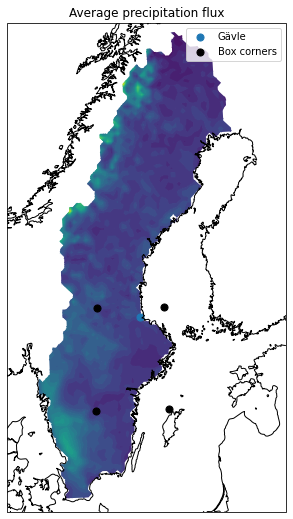

In [334]:
# Gävle point
lat = 60.73284099330242
lon = 17.09885344649177
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={"projection": sweref})
iplt.contourf(clim_cube, 30, axes=ax)
ax.scatter([lon], [lat], s=50, transform=ccrs.PlateCarree(),
           label="Gävle")
mask_points = [[14.5, 14.5,  18.5, 18.5], [58., 61., 58., 61.]]
ax.scatter(mask_points[0], mask_points[1], s=50, c="k",
           transform=ccrs.PlateCarree(), label="Box corners")

ax.coastlines();
ax.legend();
ax.set_title("Average precipitation flux");

We then have to convert the coordinates to the CoordSystem of our cube.

In [335]:
# Get the coord system of the cube. Convert it to cartopy.
target_projection = cube.coord_system().as_cartopy_projection()

In [336]:
# Convert mask points to ndarray
points = np.asarray(mask_points)
# Transform them to the cube projection.
transformed_points = target_projection.transform_points(ccrs.PlateCarree(),
                                                        points[0,:],
                                                        points[1, :]
                                                       )

Create a constraint from the converted corner coordinates.

In [337]:
# Create the constraint.
region_constraint = iris.Constraint(grid_latitude=lambda v: transformed_points[:, 1].min() <= v <= transformed_points[:, 1].max(),
                                    grid_longitude=lambda v : transformed_points[:, 0].min() <= v <= transformed_points[:, 0].max()
                                   )

In [338]:
# And extract the region.
reg_cube = cube.extract(region_constraint)

In [339]:
# reg_cube

Look at the selected data.

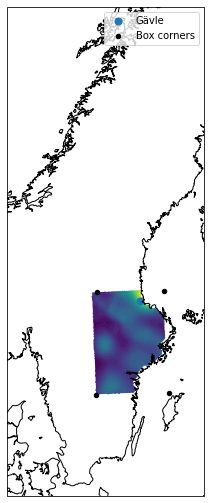

In [340]:
# Gävle point
lat = 60.73284099330242
lon = 17.09885344649177
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={"projection": sweref})
iplt.contourf(reg_cube[0, :, :], 30, axes=ax)
ax.scatter([lon], [lat], s=50, transform=ccrs.PlateCarree(),
           label="Gävle")
ax.scatter(mask_points[0], mask_points[1], s=20, c="k",
           transform=ccrs.PlateCarree(), label="Box corners")

ax.coastlines();
ax.legend();
# Set the extent to put the data into context.
ax.set_extent([10, 20, 50, 75], crs=ccrs.PlateCarree())

## Fitting an extreme value distribution to Rx1
Now we can start looking at the extremes, e.g. annual Rx1.
In this case Rx1 should simply be the annual max? Since we already have daily values.

In [344]:
# Add a year categorisation
iris.coord_categorisation.add_year(reg_cube, "time")

Get the annual maximums

In [345]:
rx1_ann = reg_cube.aggregated_by("year", iris.analysis.MAX)

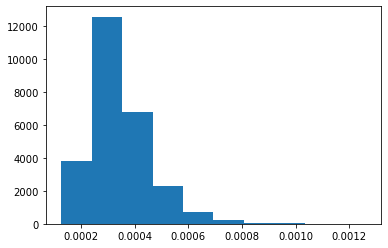

In [346]:
plt.hist(rx1_ann.data.compressed());

### Fit a GEV distribution.
We use scipy to fit a GEV distribution to this sample.

In [347]:
# Get the dist object
dist = scstats.genextreme
# data
data = rx1_ann.data.compressed()
# And fit the data
fit = dist.fit(data)

In [86]:
dist.fit(data)

(-0.795910939921078, 0.0002952460152584229, 0.0001382937845368818)

In [25]:
data.shape

(24360,)

In [55]:
# A very simply bootstrap.
def bootstrap_fit(data, n_resamples=50):
    # We use the global dist object.
    global dist
    # We know how many results we need.
    results = np.zeros((n_resamples, 3))
    # Generate all the resamples before the loop.
    # This is basically sampling with replacement.
    indices = np.random.randint(0, data.shape[0], (n_resamples, data.shape[0]))
    # We then loop over the different combinations and fit the distribtuion.
    for i, inds in tqdm(enumerate(indices)):
        res = dist.fit(data[..., inds])
        # Save fit params.
        results[i, :] = res
    return results
        

In [58]:
# We get an nx3 array of the fit params.
results = bootstrap_fit(data, n_resamples=1000)

1000it [14:39,  1.14it/s]


In [232]:
fits_ci = np.quantile(results, [0, 0.05, 0.5, 0.95, 1], axis=0)

In [233]:
fits_ci

array([[-7.99632148e-01,  2.89575908e-04,  8.09204249e-05],
       [-7.97576902e-01,  2.92700819e-04,  1.32645940e-04],
       [-7.95955634e-01,  2.95061756e-04,  1.38132258e-04],
       [-7.95052698e-01,  2.96676436e-04,  1.40299543e-04],
       [-4.86727427e-02,  2.98093840e-04,  1.41611374e-04]])

## Regression to GMST
To scale the above distribution with the use of GMST we first need to fit a regression between the Rx1 and GMST.
The slope of the regression can then be used for the scaling.

But first we load the GISTEMP data from NASA.

In [101]:
df = pd.read_csv("/home/sm_erhol/attribution/data/gistemp.txt",
                 sep="\s+",
                 header=2,
                )

In [102]:
# We don't need the first row.
df = df.drop(0)
df = df.reset_index(drop=True)

In [103]:
df.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.17,-0.10
1,1881,-0.09,-0.13
2,1882,-0.11,-0.17
3,1883,-0.18,-0.20
4,1884,-0.28,-0.24


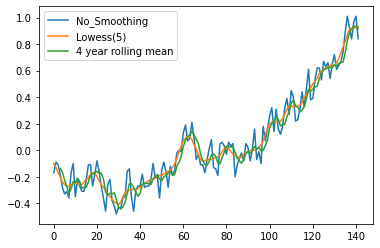

In [104]:
df.plot()
df["No_Smoothing"].rolling(4).mean().plot(label="4 year rolling mean")
plt.legend();

Before we do the regression we have smooth the GMST data.
What type of smoothing should be applied varies in the literature.
Since this can easily be changed later, we go for a 4 year rolling mean now.

In [105]:
# What years does the Rx1 data span?
first_year = rx1_ann.coord("year").points[0]
last_year = rx1_ann.coord("year").points[-1]

In [106]:
# Cast the year column of GMST df to int.
df.Year = df.Year.astype(int)

In [107]:
# Create a column with a 4yr rolling mean.
df["4yr_smooth"] = df["No_Smoothing"].rolling(4).mean()

Select the year we are interested in.

In [108]:
# Select years to match gridclim.
gmst = df[(df.Year >= first_year) & (df.Year <= last_year)].reset_index(drop=True)

In [109]:
gmst.head()

,Year,No_Smoothing,Lowess(5),4yr_smooth
0,1961,0.06,0.01,0.0300
1,1962,0.03,-0.01,0.0225
2,1963,0.05,-0.03,0.0275
3,1964,-0.20,-0.04,-0.0150
4,1965,-0.11,-0.05,-0.0575


Now we can do the regression between the GMST and the Rx1.

In [110]:
# Lets get the data of the rx1 cube.
rx1_ann_data = rx1_ann.data.reshape(58, -1)

In [111]:
rx1_ann_data.shape

(58, 420)

In [112]:
gmst_data = gmst["4yr_smooth"].to_numpy().reshape((58, 1))
gmst_data.shape

(58, 1)

In [113]:
gmst_data = np.broadcast_to(gmst_data, rx1_ann_data.shape)

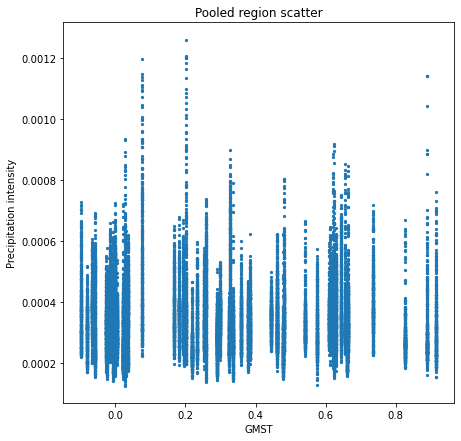

In [114]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(gmst_data.reshape(-1), rx1_ann_data.reshape(-1), s=5);
ax.set_xlabel("GMST")
ax.set_ylabel("Precipitation intensity");
ax.set_title("Pooled region scatter");

In [115]:
# Loop to do the regression for each point
# Fit a linear regression, save the slope and intercept
linear_model = scstats.linregress(gmst_data.reshape(-1), rx1_ann_data.reshape(-1))

In [116]:
linear_model

LinregressResult(slope=-1.0389673757575524e-05, intercept=0.00034897524706012806, rvalue=-0.025410751352005503, pvalue=7.294547158276135e-05, stderr=2.618926634019462e-06, intercept_stderr=1.0890983718143085e-06)

We scale the distribution by making the location and scale a function of the temperature anomaly, using the slope of the regression.

$\mu = \mu_0 \mathrm{exp}(\alpha T' / \mu_0),\, \sigma = \sigma_0\mathrm{exp}(\alpha T'/ \mu_0)$

In [117]:
def scale_fit(T, shape0, loc0, scale0, regr_slope):
    """Perform a scale fit of the distribution.
    
    Arguments
    ---------
    T : float
        Temperature anomaly to scale the distribution to.
    shape0 : float
        Shape parameter. Unaffected.
    loc0 : float
        Location parameter of the distribution.
    scale0 : float
        Scale parameter of the distribution
    regr_slop : float
        Regression slope between GMST and data of the distribution.
        
    Returns
    -------
    shape : float
    loc : float
    scale : float
    """
    
    loc = loc0 * np.exp(regr_slope * T / loc0)
    scale = scale0 * np.exp(regr_slope * T / loc0)
    
    return shape0, loc, scale

In [234]:
fits_ci

array([[-7.99632148e-01,  2.89575908e-04,  8.09204249e-05],
       [-7.97576902e-01,  2.92700819e-04,  1.32645940e-04],
       [-7.95955634e-01,  2.95061756e-04,  1.38132258e-04],
       [-7.95052698e-01,  2.96676436e-04,  1.40299543e-04],
       [-4.86727427e-02,  2.98093840e-04,  1.41611374e-04]])

In [235]:
# Create dists for the ci
dists_ci = [dist(*fit) for fit in fits_ci]

In [236]:
# Test it out
slope = linear_model[0]
# Scale the CI params.
scaled_params = [scale_fit(-1.2, *fit, slope) for fit in fits_ci] 

In [237]:
scaled_dists_ci = [dist(*params) for params in scaled_params]

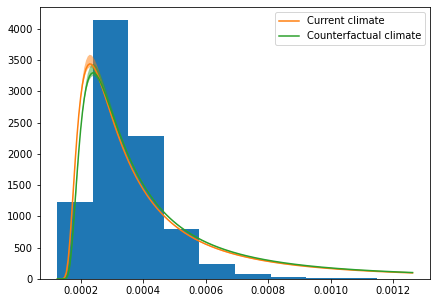

In [249]:
x = np.linspace(data.min(), data.max(), num=200)
fig, ax = plt.subplots(figsize=(7, 5))
ax.hist(data, density=True, histtype="stepfilled");
# Current climate
ax.plot(x, dists_ci[2].pdf(x), label="Current climate")
ax.fill_between(x, dists_ci[1].pdf(x), dists_ci[3].pdf(x), alpha=0.5)
# ax.fill_between(x, dists_ci[0].pdf(x), dists_ci[3].pdf(x), alpha=0.3)
# Counter factual
ax.plot(x, scaled_dists_ci[2].pdf(x), label="Counterfactual climate");
ax.fill_between(x, scaled_dists_ci[1].pdf(x), scaled_dists_ci[3].pdf(x), alpha=0.5)
# ax.fill_between(x, scaled_dists_ci[0].pdf(x), scaled_dists_ci[3].pdf(x), alpha=0.3)
plt.legend();

## Probabilities

In [211]:
# Counterfactual climate
p0 = [1 - scaled_dist.cdf(0.0018) for scaled_dist in scaled_dists_ci]

In [212]:
# Counterfactual climate
p1 = [1 - dist_ci.cdf(0.0018) for dist_ci in dists_ci]

In [213]:
PR = np.asarray(p1) / np.asarray(p0)

The probability ratio(s) (PR) for an event the magnitude of the Gävle

In [214]:
PR

array([0.94562371, 0.94616396, 0.94645807])

In [186]:
1 - (p0 / p1)

0.05376287672074165

# What about Eobs?

In [26]:
base_path_eobs = "/home/rossby/imports/obs/EOBS/EOBS24-0e/EUR-10/remap/EUR-11/day/"
files = glob.glob(base_path_eobs + "pr*.nc")

In [28]:
eobs_cube = iris.load(files)

In [31]:
removed = iris.util.equalise_attributes(eobs_cube)

In [33]:
eobs_cube = eobs_cube.concatenate_cube()

In [50]:
# We extract the data over the GridClim region. No need for all of Europe.
ref_lats = grid_latitude=cube.coord("grid_latitude").points
ref_lons = grid_longitude=cube.coord("grid_longitude").points
constraint = iris.Constraint(grid_latitude=lambda v: ref_lats.min() <= v <= ref_lats.max(),
                             grid_longitude=lambda v: ref_lons.min() <= v <= ref_lons.max()
                            )

In [46]:
# Extract.
eobs_cube = eobs_cube.extract(constraint)

In [65]:
eobs_cube

<iris 'Cube' of precipitation_flux / (kg m-2 s-1) (time: 25933; grid_latitude: 162; grid_longitude: 110)>

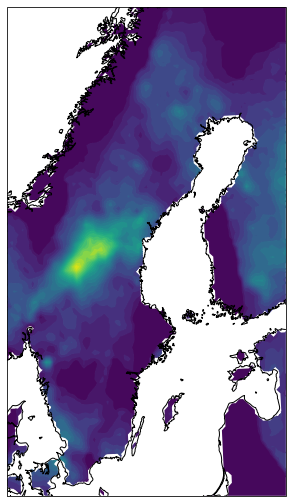

In [59]:
fig, ax = plt.subplots(figsize=(7, 9), subplot_kw={"projection": sweref})
iplt.contourf(eobs_cube[-1, :, :], 25)
ax.coastlines();

In [68]:
# Highest intensity in eobs.
eobs_cube.data.max()

0.0020766684